In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

In [3]:
from Cfg import Cfg
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")
from SplitCorpus import SplitCorpus
from glob import glob
from load_pretrained_model import load_pretrained_model
import soundfile as sf
import numpy as np
import librosa
from Clip import Clip
import torch
from collect_false import collect_false
from transcribe import transcribe
from play import play
from unidecode import unidecode

[NeMo W 2020-10-21 20:09:17 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-21 20:09:17 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToBPEDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-21 20:09:17 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.AudioLabelDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-21 20:09:17 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text._TarredAudioToTextDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-21 20:09:17 experimental:28] Module <class 'nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset'> is experimental,

## Load language model

In [4]:
C = Cfg('NIST', 16000, 'pashto', 'build') 

In [5]:
model = load_pretrained_model(C, 1)

searching save/nemo_pashto/*.ckpt


[NeMo W 2020-10-21 20:09:19 modelPT:102] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: NIST/openasr20_pashto/build/train_manifest.json
    sample_rate: 16000
    labels:
    - غ
    - ش
    - ک
    - ژ
    - ړ
    - ج
    - چ
    - ښ
    - ض
    - ل
    - ئ
    - ڼ
    - ء
    - ې
    - ع
    - ذ
    - ی
    - آ
    - ث
    - ا
    - م
    - څ
    - ه
    - د
    - خ
    - پ
    - ټ
    - س
    - ص
    - ق
    - ز
    - ً
    - ف
    - ت
    - ۍ
    - ګ
    - ځ
    - ي
    - ب
    - ن
    - ر
    - ط
    - ' '
    - ډ
    - و
    - ظ
    - ح
    - ږ
    batch_size: 14
    trim_silence: true
    max_duration: 33.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    num_workers: 16
    
[NeMo W 2020-10-21 20:09:19 modelPT:109] Please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid c

[NeMo I 2020-10-21 20:09:19 features:241] PADDING: 16
[NeMo I 2020-10-21 20:09:19 features:258] STFT using torch
loaded save/nemo_pashto/pashto_20201018_232300_353596_epoch=189.ckpt


## Start with BUILD to visualize and test transcriptions

In [3]:
if __name__ == '__main__':   
    with Pool(16) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 131/131 [00:06<00:00, 19.38it/s]


In [8]:
splits=SplitCorpus.transcript_split(C, recordings)

In [23]:
artifact=splits.artifacts[10]

KEY ('pashto', 'BABEL_BP_104_52753_20120213_014050_outLine', (1241040, 1263280))
SOURCE


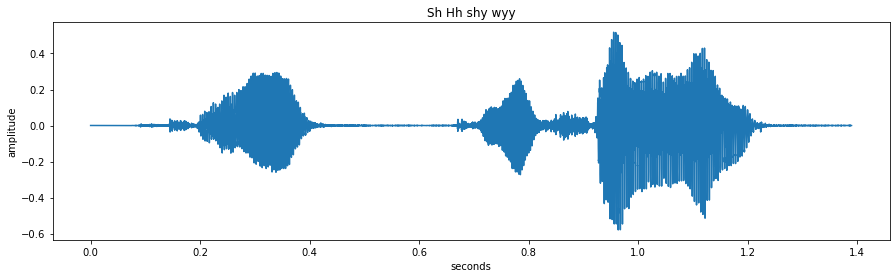

TARGET
ښه څه شی وایي :: Sh Hh shy wyy



In [24]:
artifact.display()

In [32]:
pred=transcribe(C, model, artifact.source.value)
pred

[NeMo I 2020-10-21 00:10:06 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 00:10:06 collections:174] 0 files were filtered totalling 0.00 hours


'ښه څه شی وایي'

In [34]:
pred==artifact.target.value

True

## Move onto DEV to visualize, test and refine splitter

In [6]:
C = Cfg('NIST', 16000, 'pashto', 'dev') 

In [7]:
if __name__ == '__main__':   
    with Pool(16) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 136/136 [00:06<00:00, 21.02it/s]


In [8]:
artifact=recordings.artifacts[0]

In [11]:
foo=artifact.source.n_samples

In [ ]:
audio=artifact.source.value

In [49]:
def transcribe(C, model, audio):
    cuts=[0]
    preds=[]
    while True:
        size=audio.shape[0]
        print("size", size)
        if size == 0:
            break
        max_duration=6
        max_samples=int(max_duration*C.sample_rate)
        min_samples=int(0.2*C.sample_rate)
        if size > max_samples:
            for cutoff in np.linspace(-80,-10,140):
                T=audio.shape[0]/C.sample_rate
                S = librosa.feature.melspectrogram(y=audio, sr=C.sample_rate, n_mels=64, fmax=8000)
                S_dB = librosa.power_to_db(S, ref=np.max)
                s_dB_mean=np.mean(S_dB,axis=0)
                speech_q=(s_dB_mean>cutoff)
                silences=T*collect_false(speech_q)/len(speech_q)
                # print(f'cutoff {cutoff} #silences {len(silences)}')
                S2=[(x,y) for x,y in silences if max_duration >= y > 0.001]
                if len(S2):
                    break
                cutoff += 1
                if cutoff > -18:
                    plt.figure(figsize=(60,4))
                    plt.plot(s_dB_mean)
                    plt.show()
                    plt.figure(figsize=(60,4))
                    plt.plot(audio);
                    raise ValueError('couldnt split clip')
            S3=int(S2[-1][-1]*C.sample_rate)
        else:
            S3=size
        clip=audio[0:S3]
        pred=transcribe(C, model, clip)
        cuts.append(S3)
        preds.append(pred)
        if pred != '':
            print(f"sample size in seconds {S3/C.sample_rate} pred {pred} :: {unidecode(pred)}")
            # play(clip)
        audio=audio[S3:]
        if audio.shape[0] < min_samples:
            break

    times=np.cumsum(cuts)/C.sample_rate
    transcript=[(times[i], times[i+1], preds[i]) for i in range(len(preds)) if preds[i]]
    
    return transcript

In [36]:
import pandas as pd
pd.DataFrame(transcript, columns=['start', 'end', 'pred'])

size 9600960
[NeMo I 2020-10-21 20:51:18 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:51:18 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 5.5359375 pred وععلیک السلام :: w``lykh lslm
size 9512385
[NeMo I 2020-10-21 20:51:19 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:51:19 collections:174] 0 files were filtered totalling 0.00 hours
size 9511874
[NeMo I 2020-10-21 20:51:20 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:51:20 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 2.7839375 pred ښه هغکه دار يکټم پ وکرام :: Sh hGkhh dr ykhtm p wkhrm
size 9467331
[NeMo I 2020-10-21 20:51:21 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:51:21 collections:174] 0 files were filtered totalling 0.00 hours
size 9380292
[NeMo I 2020-10-21 20:51:21 collections:173

[NeMo I 2020-10-21 20:51:34 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:51:34 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 4.6719375 pred ه او هغه ک کوی ټ نې کار ن نا ونه :: h w hGh kh khwy t n khr n n wnh
size 7378912
[NeMo I 2020-10-21 20:51:34 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:51:34 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 1.3759375 pred ښهه :: Shh
size 7356897
[NeMo I 2020-10-21 20:51:38 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:51:38 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 4.9599375 pred هغې کښه هنې څې غه را کړې یمې ویو و کا مرالته وکړه یو س پیځه یو کښې ځان سره مره وګرو بوس دیاو زه :: hG khSh hn H Gh r khR ym wyw w kh mrlth wkhRh yw s py'hh yw khS 'hn srh mrh wKrw bws dyw zh
size 7277538
[NeMo I 2020-10-21 20:51:40 

[NeMo I 2020-10-21 20:52:12 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:12 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 5.4079375 pred پېنځهش وو یالاسهته وووه ر ګنټولو کر کې هلکه څوکو که سکست دې م وشه خو بیبه :: pn'hhsh ww ylshth wwwh r Kntwlw khr kh hlkhh Hwkhw khh skhst d m wshh khw bybh
size 5912572
[NeMo I 2020-10-21 20:52:13 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:13 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 4.5119375 pred ارامنه شې و کهنه نه کا اوګنشو نو بیې ختهنه ناسته پې بته نه لګګې :: rmnh sh w khhnh nh kh wKnshw nw by khthnh nsth p bth nh lKK
size 5840381
[NeMo I 2020-10-21 20:52:13 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:13 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 1.7919375 pred هو :: hw
size 5811710
[NeMo 

[NeMo I 2020-10-21 20:52:33 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 4.5435625 pred خمله :: khmlh
size 4083359
[NeMo I 2020-10-21 20:52:34 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:34 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 5.8554375 pred او خغو نه خو دا دسېونه کنیه :: w khGw nh khw d dswnh khnyh
size 3989672
[NeMo I 2020-10-21 20:52:34 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:34 collections:174] 0 files were filtered totalling 0.00 hours
size 3941549
[NeMo I 2020-10-21 20:52:35 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:35 collections:174] 0 files were filtered totalling 0.00 hours
size 3941038
[NeMo I 2020-10-21 20:52:35 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:35 collections:174] 0 files were filtered 

[NeMo I 2020-10-21 20:52:53 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:53 collections:174] 0 files were filtered totalling 0.00 hours
size 2546997
[NeMo I 2020-10-21 20:52:54 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:54 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 2.0798125 pred اښه :: Sh
size 2513720
[NeMo I 2020-10-21 20:52:54 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:54 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 2.81575 pred هو :: hw
size 2468668
[NeMo I 2020-10-21 20:52:55 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:52:55 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 5.4715625 pred او نان سره خوفه شوي که نه پشانې ینشنکښې را شي نو د سهغې ددر ا نهښه درګې م نه وخوتو و ته خو وللې بی

[NeMo I 2020-10-21 20:53:05 collections:174] 0 files were filtered totalling 0.00 hours
size 1009594
[NeMo I 2020-10-21 20:53:05 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:53:05 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 0.6399375 pred ه :: h
size 999355
[NeMo I 2020-10-21 20:53:05 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:53:05 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 5.5355625 pred دغه دی خو مککی و خومل لم شوي وو جهراغلې دي وه همدل چېچرا لووې که نه لاښه شم پین بار دي :: dGh dy khw mkhkhy w khwml lm shwy ww jhrGl dy wh hmdl chchr lww khh nh lSh shm pyn br dy
size 910786
[NeMo I 2020-10-21 20:53:05 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-21 20:53:05 collections:174] 0 files were filtered totalling 0.00 hours
sample size in seconds 5.183625 pred امر ضیب نو د غه درانو :: mr

## Manual clip editor to break down overly long BUILD clips and reduce max_duration for training

## Find long audio short transcription length as candidates for break down

## Find very long transcription clips as candidates for break down

## Find long transcription short audio clips as candidates for rejection

## After as much corpus breakdown as possible, look at bad predictions as possible bad annotations